# Colab Setup

In [0]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print("accelerator:", accelerator)
!pip install lxml==4.0
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

# get terminator
!pip install fastai

# may not be necessary
!apt-get install -y libtiff5-dev

# on some of the VMs PIL is borked
# I am doing this out of abundance of caution
#!CC="cc -mavx2" pip install -U --force-reinstall pillow-simd
!pip install --force-reinstall scipy

!apt install ffmpeg

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Linear-Regression-problem" data-toc-modified-id="Linear-Regression-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Regression problem</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gradient Descent</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent---Classification" data-toc-modified-id="Gradient-Descent---Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient Descent - Classification</a></div><div class="lev1 toc-item"><a href="#Gradient-descent-with-numpy" data-toc-modified-id="Gradient-descent-with-numpy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gradient descent with numpy</a></div>

In [0]:
%matplotlib inline
from fastai.learner import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [0]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

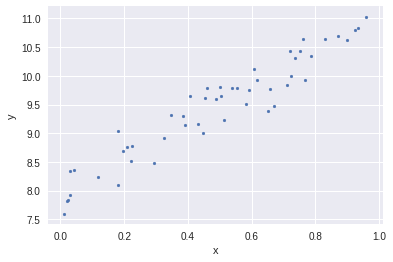

In [43]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

You want to find **parameters** (weights) $a$ and $b$ such that you minimize the *error* between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

In [0]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute `y_hat` which is our *prediction* and then compute our error.

In [45]:
y_hat = lin(10,5,x)
mse(y_hat, y)

3.8177913160004766

In [0]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [47]:
mse_loss(10, 5, x, y)

3.8177913160004766

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for $a$ and $b$? How do we find the best *fitting* linear regression.

# Gradient Descent

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [64]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [0]:
x,y = V(x),V(y)

In [66]:
# Create random weights a and b, and wrap them in Variables.
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
  0.4219
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.8692
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [67]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(a.data[0] ,"\t",b.data[0],"\t",loss.data[0])
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()    

0.4218537211418152 	 0.8691758513450623 	 71.81349182128906
3.593982696533203 	 7.013169288635254 	 0.5895554423332214
3.7434611320495605 	 7.5446906089782715 	 0.14260192215442657
3.6694576740264893 	 7.632517337799072 	 0.1285344362258911
3.588559627532959 	 7.680080890655518 	 0.11971037834882736
3.516348123550415 	 7.719509124755859 	 0.11293169856071472
3.452902317047119 	 7.753925323486328 	 0.10771466046571732
3.3972346782684326 	 7.784093379974365 	 0.10369984060525894
3.348400354385376 	 7.81056022644043 	 0.10060996562242508
3.3055598735809326 	 7.833786487579346 	 0.09823178499937057


Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient Descent - Classification

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [0]:
def gen_fake_data2(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, np.where(y>10, 1, 0).astype(np.float32)

In [0]:
x,y = gen_fake_data2(10000, 3., 8.)
x,y = V(x),V(y)

In [0]:
def nll(y_hat, y):
    y_hat = torch.clamp(y_hat, 1e-5, 1-1e-5)
    return (    y*y_hat.log()   +   (1-y)*(1-y_hat).log()             ).mean()

In [0]:
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)

In [82]:
learning_rate = 1e-2
for t in range(3000):
    p = (-lin(a,b,x)).exp()
    y_hat = 1/(1+p)
    loss = nll(y_hat,y)
    if t % 1000 == 0:
        print(loss.data[0], np.mean(to_np(y)==(to_np(y_hat)>0.5)))
#         print(y_hat)
    
    loss.backward()
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    a.grad.data.zero_()
    b.grad.data.zero_()    

-0.6936511397361755 0.6575
-1.6703168153762817 0.6575
-3.584855079650879 0.6575


Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient descent with numpy

In [0]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'


In [0]:
x, y = gen_fake_data(50, 3., 8.)

In [85]:
a_guess,b_guess = -1., 1.
mse_loss(a_guess, b_guess, x, y)

87.03987535673694

In [0]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

In [87]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani